In [125]:
import xarray as xr
import numpy as np
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import pandas as pd

import cartopy.crs as ccrs
import cartopy.mpl.ticker as cticker
from cartopy.util import add_cyclic_point

import matplotlib as mpl
from matplotlib import cm
import matplotlib.cbook as cbook
import matplotlib.colors as colors

import time
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [126]:
#opening the PNA index file. It is a monthly index from Jan 1948-Dec 2020
#it also removes the nan values which are -99 

path='/home/pdirmeye/classes/clim680_2022/CLIM_INDICES/'
file='pna.data'
index_name='pna'

df=pd.read_table(path+file,skiprows=1,
                 header=None,delim_whitespace=True,
                 index_col=0,parse_dates=True,
                 na_values=['-99.9','-99.90'])
df.drop(df.tail(3).index,inplace=True)

In [127]:
#The date which it labels will be at the end of the month
start_date=str(df.index[0])+'-'+str(df.columns[0])+'-31'
end_date=str(df.index[-1])+'-'+str(df.columns[-1])+'-31'
dates=pd.date_range(start=start_date,end=end_date,freq='M')
dates

DatetimeIndex(['1948-01-31', '1948-02-29', '1948-03-31', '1948-04-30',
               '1948-05-31', '1948-06-30', '1948-07-31', '1948-08-31',
               '1948-09-30', '1948-10-31',
               ...
               '2020-03-31', '2020-04-30', '2020-05-31', '2020-06-30',
               '2020-07-31', '2020-08-31', '2020-09-30', '2020-10-31',
               '2020-11-30', '2020-12-31'],
              dtype='datetime64[ns]', length=876, freq='M')

In [128]:
#unstacks the data 
clim_index=df.T.unstack().values
clim_index=clim_index.astype('float32')

In [129]:
#puts all the data into a data array and shows the dataset
ds_index=xr.DataArray(clim_index,
                      coords={'time':dates},
                              dims=['time'])        
ds_index=ds_index.to_dataset(name='pna')
ds_index

<xarray.Dataset>
Dimensions:  (time: 876)
Coordinates:
  * time     (time) datetime64[ns] 1948-01-31 1948-02-29 ... 2020-12-31
Data variables:
    pna      (time) float32 nan nan nan nan nan nan ... 1.2 1.8 0.59 nan nan nan

In [130]:
#slicing the dataset to match the length of the z500mb dataset from era interim
ds_index_500= ds_index.sel(time=slice('1979-01-31','2019-08-31'))
ds_index_500

<xarray.Dataset>
Dimensions:  (time: 488)
Coordinates:
  * time     (time) datetime64[ns] 1979-01-31 1979-02-28 ... 2019-08-31
Data variables:
    pna      (time) float32 -1.54 -2.73 0.08 -0.15 1.27 ... -0.17 0.24 0.62 1.16

In [131]:
#Trying to abstract on the months of dec, jan, feb from the pna index to see
#CAO are typically associated with positive phase of the PNA 
#trying to see how often out of the time period from does the PNA appear positive or negative for the months during the winter season

months_to_extract = [12, 1, 2]  # December, January, and February

# Filter the dataset to include the specified months
ds_index_djf = ds_index_500.where(ds_index_500['time.month'].isin(months_to_extract), drop=True)
ds_index_djf

<xarray.Dataset>
Dimensions:  (time: 122)
Coordinates:
  * time     (time) datetime64[ns] 1979-01-31 1979-02-28 ... 2019-02-28
Data variables:
    pna      (time) float32 -1.54 -2.73 -0.68 -1.01 ... -1.67 0.56 0.42 -1.73

In [132]:
#Subsetting data into 2 different arrays based on the pacific north american pattern (not oscillation...)

#Usually there is a positive and negative phase. 
#Positive= at surface: warmer, drier conditions on the western US. Cooler, wetter condition on eastern/ southeastern US
#          at 500mb ridge in the northeastern pacific and trough in the central and eastern US
#Negative= reversed a both surface and 500mb height
#
#ENSO affects pattern since in Pacific

postive1 = ds_index_djf['pna'].where(ds_index_djf['pna']>0) # nans where false and unaltered where true if only first parameter given
negative1 = ds_index_djf['pna'].where(ds_index_djf['pna']<=0)




In [133]:
#Counts the number of times there is positive phase and negative phase for time range

print('Positive Phase of PNA: ',postive1.count(dim='time').values)

print('Negative Phase of PNA: ',negative1.count(dim='time').values)

counts=[postive1.count(dim='time').values,
        negative1.count(dim='time').values,]
print(counts)

Positive Phase of PNA:  69
Negative Phase of PNA:  53
[array(69), array(53)]


''

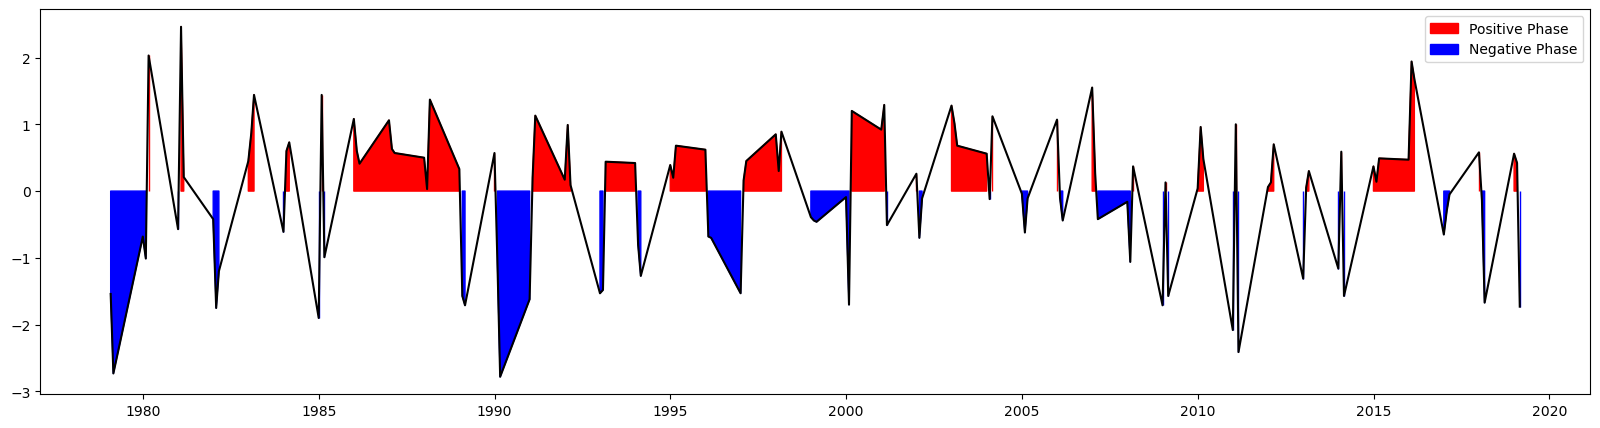

In [134]:
#Plotting and filling in the PNA index

plt.figure(figsize=(20,5))
plt.plot(ds_index_djf['time'],ds_index_djf['pna'],linestyle= "-", color= "black")
plt.fill_between(ds_index_djf['time'].values,postive1,y2=0,color='red', label="Positive Phase")
plt.fill_between(ds_index_djf['time'].values,negative1,y2=0,color='blue', label="Negative Phase")
plt.legend()
;

In [135]:
#Opening 500mb dataset

file = "/scratch/kbarrag/clim680_dataset/mean/erai.z500.day.mean.1979-2019.nc"
ds = xr.open_dataset(file)
ds

<xarray.Dataset>
Dimensions:  (lon: 512, lat: 128, time: 14853)
Coordinates:
  * lon      (lon) float64 0.0 0.7031 1.406 2.109 ... 357.2 357.9 358.6 359.3
  * lat      (lat) float64 0.351 1.053 1.754 2.456 ... 87.37 88.07 88.77 89.46
  * time     (time) datetime64[ns] 1979-01-01 1979-01-02 ... 2019-08-31
Data variables:
    z500     (time, lat, lon) float32 ...

In [136]:
# Create a monthly mean for every month of the daily data :|
z500_monthly = ds.resample(time='M').mean(dim='time')
z500_monthly

<xarray.Dataset>
Dimensions:  (lon: 512, lat: 128, time: 488)
Coordinates:
  * lon      (lon) float64 0.0 0.7031 1.406 2.109 ... 357.2 357.9 358.6 359.3
  * lat      (lat) float64 0.351 1.053 1.754 2.456 ... 87.37 88.07 88.77 89.46
  * time     (time) datetime64[ns] 1979-01-31 1979-02-28 ... 2019-08-31
Data variables:
    z500     (time, lat, lon) float32 5.754e+04 5.754e+04 ... 5.326e+04

In [137]:
months_to_extract = [12, 1, 2] 
ds_djf = z500_monthly.where(ds['time.month'].isin(months_to_extract), drop=True)
ds_djf

<xarray.Dataset>
Dimensions:  (time: 122, lat: 128, lon: 512)
Coordinates:
  * lon      (lon) float64 0.0 0.7031 1.406 2.109 ... 357.2 357.9 358.6 359.3
  * lat      (lat) float64 0.351 1.053 1.754 2.456 ... 87.37 88.07 88.77 89.46
  * time     (time) datetime64[ns] 1979-01-31 1979-02-28 ... 2019-02-28
Data variables:
    z500     (time, lat, lon) float32 5.754e+04 5.754e+04 ... 4.877e+04

In [138]:
ds_djf_monthly_climo=ds_djf.z500.groupby("time.month").mean()
ds_djf_monthly_climo

<xarray.DataArray 'z500' (month: 3, lat: 128, lon: 512)>
array([[[57511.99 , 57511.98 , 57511.51 , ..., 57514.426, 57513.355,
         57512.73 ],
        [57513.58 , 57513.047, 57512.67 , ..., 57515.75 , 57515.164,
         57514.074],
        [57514.   , 57513.055, 57513.28 , ..., 57517.01 , 57515.992,
         57514.34 ],
        ...,
        [49720.58 , 49720.94 , 49721.29 , ..., 49719.547, 49719.887,
         49720.24 ],
        [49727.727, 49727.92 , 49728.105, ..., 49727.188, 49727.375,
         49727.555],
        [49743.33 , 49743.42 , 49743.52 , ..., 49743.07 , 49743.156,
         49743.242]],

       [[57535.86 , 57535.742, 57535.26 , ..., 57538.477, 57537.48 ,
         57536.816],
        [57538.51 , 57537.88 , 57537.336, ..., 57541.105, 57540.543,
         57539.273],
        [57540.902, 57539.793, 57539.867, ..., 57544.367, 57543.312,
         57541.41 ],
...
        [49739.547, 49739.926, 49740.31 , ..., 49738.367, 49738.78 ,
         49739.16 ],
        [49730.58 , 49730.805, 49731.02 , ..., 49729.895, 49730.133,
         49730.355],
        [49731.035, 49731.152, 49731.28 , ..., 49730.676, 49730.8  ,
         49730.918]],

       [[57503.01 , 57502.79 , 57502.05 , ..., 57505.15 , 57504.375,
         57503.887],
        [57504.938, 57504.23 , 57503.617, ..., 57506.793, 57506.387,
         57505.426],
        [57506.176, 57505.105, 57505.15 , ..., 57508.5  , 57507.793,
         57506.4  ],
        ...,
        [49857.387, 49857.297, 49857.21 , ..., 49857.676, 49857.574,
         49857.48 ],
        [49868.492, 49868.43 , 49868.363, ..., 49868.707, 49868.637,
         49868.555],
        [49887.027, 49887.016, 49887.02 , ..., 49887.043, 49887.03 ,
         49887.023]]], dtype=float32)
Coordinates:
  * lon      (lon) float64 0.0 0.7031 1.406 2.109 ... 357.2 357.9 358.6 359.3
  * lat      (lat) float64 0.351 1.053 1.754 2.456 ... 87.37 88.07 88.77 89.46
  * month    (month) int64 1 2 12
Attributes:
    long_name:  Geoptential at 500 hPa
    units:      m**2 s**-2

Text(0.5, 0.98, '500mb Monthly Mean Climatology ')

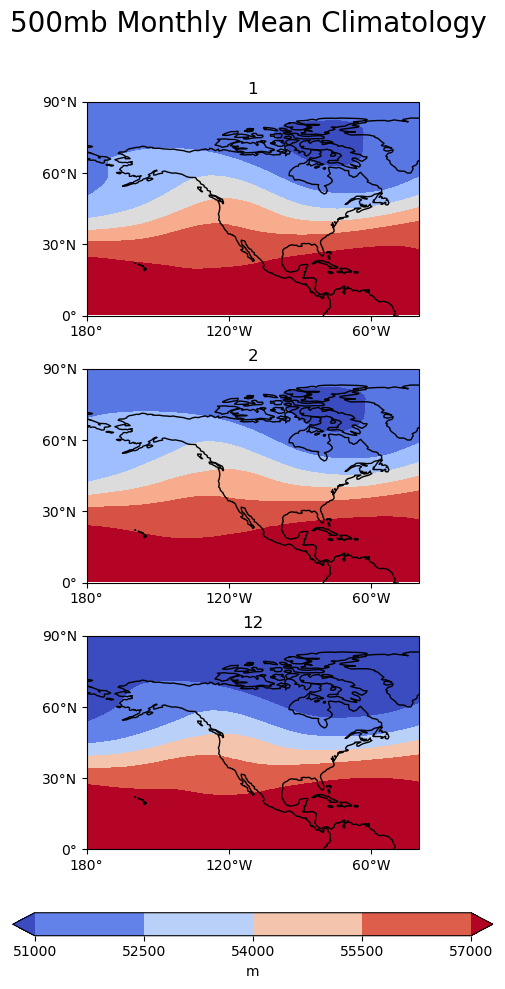

In [139]:
#Plotting the climotology to make sure its going ok.Plot not perfect in color. Does not show pattern. 

#Define the figure and each axis for the 2 rows and 2 columns
fig, axs = plt.subplots(nrows=3,ncols=1,
                        subplot_kw={'projection': ccrs.PlateCarree()},
                        figsize=(8,11.5))

# axs is a 2 dimensional array of `GeoAxes`.  
# We will flatten it into a 1-D array
axs=axs.flatten()

#Loop over all of the seasons and plot
for i,month in enumerate(ds_djf_monthly_climo['month']):

        # Select the season
        data=ds_djf_monthly_climo.sel(month=month)

        # Add the cyclic point
        data,lons=add_cyclic_point(data,coord=ds_djf_monthly_climo['lon'])

        # Contour plot
        cs=axs[i].contourf(lons,ds_djf_monthly_climo['lat'],data,
                          transform = ccrs.PlateCarree(),
                          cmap='coolwarm',extend='both')

       # Longitude labels
        axs[i].set_xticks(np.arange(-180,181,60), crs=ccrs.PlateCarree())
        lon_formatter = cticker.LongitudeFormatter()
        axs[i].xaxis.set_major_formatter(lon_formatter)
         # Latitude labels
        axs[i].set_yticks(np.arange(-90,91,30), crs=ccrs.PlateCarree())
        lat_formatter = cticker.LatitudeFormatter()
        axs[i].yaxis.set_major_formatter(lat_formatter)

        # Title each subplot with the name of the season
        axs[i].set_title(month.values)

        # Draw the coastines for each subplot
        axs[i].coastlines()
        axs[i].set_extent([-180, -40, 90, 0], ccrs.PlateCarree())        
# Adjust the location of the subplots 
# on the page to make room for the colorbar
fig.subplots_adjust(bottom=0.25, top=0.9, left=0.05, right=0.95,
                    wspace=0.2, hspace=0.25)

# Add a colorbar axis at the bottom of the graph
cbar_ax = fig.add_axes([0.2, 0.175, 0.6, 0.02])

# Draw the colorbar
cbar=fig.colorbar(cs, cax=cbar_ax,orientation='horizontal',label='m')

# Add a big title at the top
plt.suptitle('500mb Monthly Mean Climatology ',fontsize=20)

In [140]:
#Here will get the anomaly
#from the anomaly will be able to see how PNA looks when the anomalies are a certain way

da_anoms_djf = ds_djf.z500.groupby('time.month')- ds_djf_monthly_climo
da_anoms_djf

<xarray.DataArray 'z500' (time: 122, lat: 128, lon: 512)>
array([[[  29.148438 ,   29.519531 ,   30.488281 , ...,   30.308594 ,
           29.644531 ,   29.1875   ],
        [  28.527344 ,   29.308594 ,   30.433594 , ...,   30.015625 ,
           29.441406 ,   28.835938 ],
        [  28.78125  ,   29.453125 ,   30.035156 , ...,   30.011719 ,
           29.5625   ,   28.835938 ],
        ...,
        [ 576.10156  ,  574.6094   ,  573.21484  , ...,  580.66016  ,
          579.10156  ,  577.5625   ],
        [ 653.9375   ,  652.8789   ,  651.8906   , ...,  657.14844  ,
          656.03125  ,  654.9883   ],
        [ 727.5625   ,  727.01953  ,  726.4922   , ...,  729.16797  ,
          728.60547  ,  728.0781   ]],

       [[  41.98828  ,   40.277344 ,   38.371094 , ...,   45.40625  ,
           44.546875 ,   43.273438 ],
        [  42.210938 ,   40.28125  ,   38.51953  , ...,   46.01172  ,
           45.277344 ,   43.753906 ],
        [  42.35547  ,   40.375    ,   38.54297  , ...,   46.703125 ,
           45.95703  ,   44.046875 ],
...
        [   5.3554688,    5.0273438,    4.703125 , ...,    6.3320312,
            6.       ,    5.6953125],
        [  -9.371094 ,   -9.7265625,  -10.097656 , ...,   -8.308594 ,
           -8.65625  ,   -9.015625 ],
        [  -6.6679688,   -6.9453125,   -7.1328125, ...,   -6.046875 ,
           -6.2773438,   -6.4765625]],

       [[ 130.33594  ,  129.79297  ,  128.48828  , ...,  134.4414   ,
          133.04688  ,  131.84375  ],
        [ 130.30078  ,  129.96875  ,  129.2461   , ...,  134.6875   ,
          133.38672  ,  132.1211   ],
        [ 130.57812  ,  130.16406  ,  129.33984  , ...,  133.91797  ,
          133.52734  ,  132.58203  ],
        ...,
        [-829.1719   , -832.02344  , -834.9336   , ..., -820.5625   ,
         -823.41406  , -826.2656   ],
        [-896.0703   , -898.0547   , -900.0742   , ..., -890.16406  ,
         -892.1406   , -894.08594  ],
        [-959.34766  , -960.26953  , -961.22656  , ..., -956.6133   ,
         -957.5156   , -958.4453   ]]], dtype=float32)
Coordinates:
  * lon      (lon) float64 0.0 0.7031 1.406 2.109 ... 357.2 357.9 358.6 359.3
  * lat      (lat) float64 0.351 1.053 1.754 2.456 ... 87.37 88.07 88.77 89.46
  * time     (time) datetime64[ns] 1979-01-31 1979-02-28 ... 2019-02-28
    month    (time) int64 1 2 12 1 2 12 1 2 12 1 2 ... 1 2 12 1 2 12 1 2 12 1 2

In [141]:
#Here matching the anomalies with the PNA pattern
#dropna= drops na values
postivephase_ = da_anoms_djf.sel(time=postive1.dropna(dim='time')['time']).mean(dim='time')
negativephase_ = da_anoms_djf.sel(time=negative1.dropna(dim='time')['time']).mean(dim='time')

comp_positive1 = [postivephase_, negativephase_]
comp_positive1

[<xarray.DataArray 'z500' (lat: 128, lon: 512)>
 array([[ 21.701992 ,  21.829144 ,  21.973335 , ...,  21.316973 ,
          21.427084 ,  21.590466 ],
        [ 21.570482 ,  21.716486 ,  21.810518 , ...,  21.146513 ,
          21.222599 ,  21.37234  ],
        [ 21.302933 ,  21.436197 ,  21.557688 , ...,  20.981884 ,
          21.033854 ,  21.157948 ],
        ...,
        [-13.261322 , -13.182915 , -13.1074505, ..., -13.479676 ,
         -13.411628 , -13.3375225],
        [-12.265116 , -12.212636 , -12.1529665, ..., -12.424536 ,
         -12.376359 , -12.318444 ],
        [-11.292346 , -11.263078 , -11.24615  , ..., -11.370018 ,
         -11.344882 , -11.316803 ]], dtype=float32)
 Coordinates:
   * lon      (lon) float64 0.0 0.7031 1.406 2.109 ... 357.2 357.9 358.6 359.3
   * lat      (lat) float64 0.351 1.053 1.754 2.456 ... 87.37 88.07 88.77 89.46,
 <xarray.DataArray 'z500' (lat: 128, lon: 512)>
 array([[-28.261055 , -28.4162   , -28.612766 , ..., -27.758327 ,
         -27.896816 , -

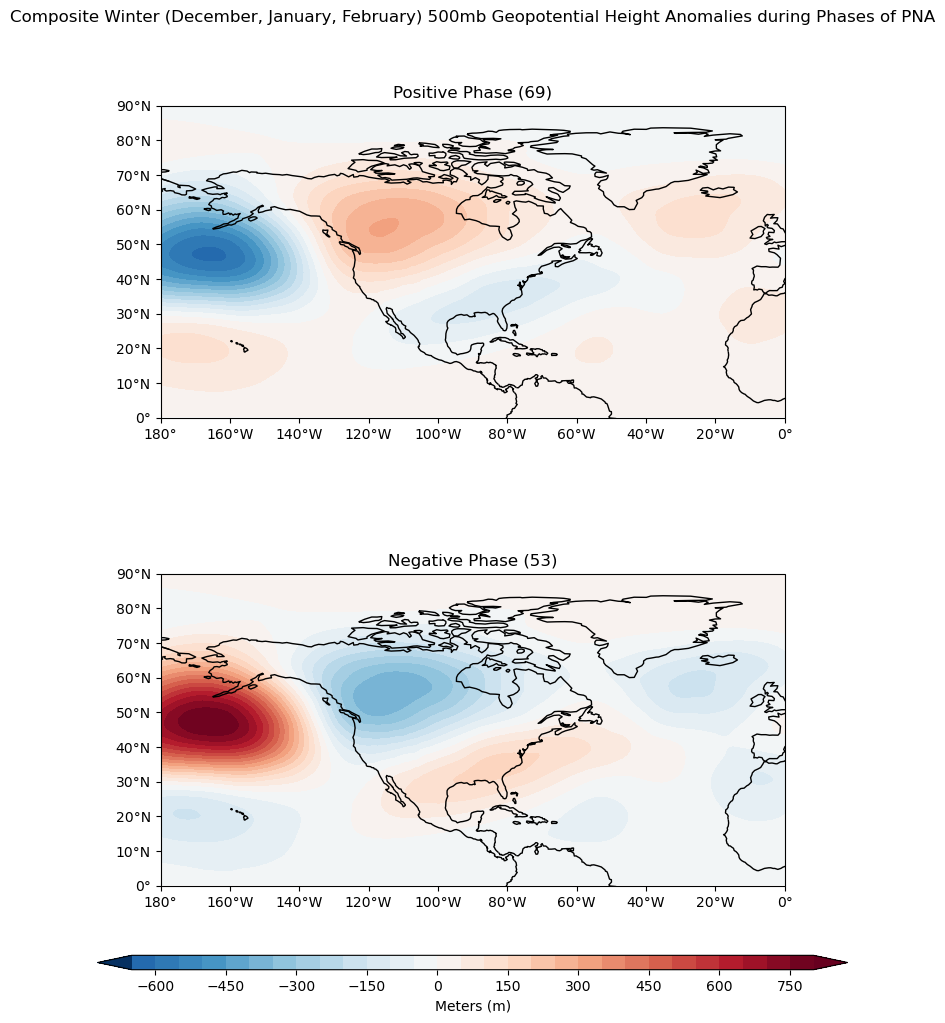

In [144]:
#Plotting with 2 panels 

labels=['Positive Phase','Negative Phase']
clevs = np.arange(-650,850,50)


divnorm = colors.CenteredNorm(vcenter=0)


# Define the figure and each axis for the 3 rows and 3 columns
fig, axs = plt.subplots(nrows=2,ncols=1,
                        subplot_kw={'projection': ccrs.PlateCarree()},
                        figsize=(15,12))



divnorm = colors.CenteredNorm(vcenter=0)

# axs is a 2 dimensional array of `GeoAxes`.  
# We will flatten it into a 1-D array (just 3 rows)
axs = axs.flatten()

#Loop over all of the seasons and plot
for i,month in enumerate(comp_positive1):

        # Select the season
        data = comp_positive1[i]

        # Add the cyclic point
        data,lons = add_cyclic_point(data,coord=comp_positive1[i]['lon'])

        # Contour plot
        cs=axs[i].contourf(lons,comp_positive1[i]['lat'],data,clevs,norm=divnorm,
                          transform = ccrs.PlateCarree(),
                          cmap='RdBu_r',extend='both')

       # Longitude labels
        axs[i].set_xticks(np.arange(-180,181,20), crs=ccrs.PlateCarree())
        lon_formatter = cticker.LongitudeFormatter()
        axs[i].xaxis.set_major_formatter(lon_formatter)

        # Latitude labels
        axs[i].set_yticks(np.arange(-90,91,10), crs=ccrs.PlateCarree())
        lat_formatter = cticker.LatitudeFormatter()
        axs[i].yaxis.set_major_formatter(lat_formatter)

        
        # Title each subplot with the name of the season
        axs[i].set_title(labels[i]+' ('+str(counts[i])+')')

        # Draw the coastines for each subplot
        axs[i].coastlines()
        axs[i].set_extent([-180, 0, 90, 0], ccrs.PlateCarree())   
        
# Adjust the location of the subplots 
# on the page to make room for the colorbar
fig.subplots_adjust(bottom=0.25, top=0.9, left=0.05, right=0.95,
                    wspace=0.1, hspace=0.5)

# Add a colorbar axis at the bottom of the graph
cbar_ax = fig.add_axes([0.25, 0.18, 0.5, 0.012])

# Draw the colorbar
cbar = fig.colorbar(cs,cax=cbar_ax,orientation='horizontal',label='Meters (m)')

# Add a big title at the top
plt.suptitle('Composite Winter (December, January, February) 500mb Geopotential Height Anomalies during Phases of PNA') ;